#### track package changes
!pip install --upgrade pandas --> from silent downcasting issue with fillna

!pip install segment-geospatial leafmap --> updates numpy, leafmap messes things up. should downgrade back to 1.23.5. or better yet, don't use this at all, just work in qgis

In [2]:
# !pip install git+https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping.git
# !pip install python-dotenv

  Cloning https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping.git to /tmp/pip-req-build-lbdhbtxd
  Running command git clone --filter=blob:none --quiet https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping.git /tmp/pip-req-build-lbdhbtxd
  Resolved https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping.git to commit 8addd4633c7b9fdc17e672a6763dee3535ea0d5d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Poverty Mapping and Impact Evaluation

In [2]:
# General
import os
import re
from dotenv import load_dotenv
from pathlib import Path
import gc
import time
import pickle
import math

# Mathematical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# ThinkingMachine utilities
from povertymapping import dhs, nightlights, feature_engineering
import geowrangler.raster_zonal_stats as rzs
import geopandas as gpd

# Google Earth Engine
import ee
import geemap

# Stats/Machine learning
from sklearn.preprocessing import MinMaxScaler

# Mapping
import rasterio

## Data Sources

https://data.humdata.org/dataset/philippines-high-resolution-population-density-maps-demographic-estimates?#

https://www.ciesin.columbia.edu/repository/hrsl/

## Data

### Label - DHS

We begin by extracting wealth information from the Demographic and Health Survey (DHS) dataset. This will be our label (target) for subsequent model training.

In [4]:
# Set up for extracting relevant data from DHS
COUNTRY_CODE = "ph"                                                    # Philippines as country of interest in this study
DHS_LABEL_COL = "Wealth Index"                                         # Column name as labels for model training
OUTPUT_LABEL_COL = "Wealth Index - Scaled"
TILE_SIZE_KM = 2.4                                                     # Tile size as geographic extent for each DHS cluster (unit)

# Paths for DHS material in 2017 and 2022
DHS_HOUSEHOLD_DTA_PATH_2017 = "data/dhs/ph/PHHR71DT/PHHR71FL.DTA"      # Survey data in dta (stata) format, 2017
DHS_GEOGRAPHIC_SHP_PATH_2017 = "data/dhs/ph/PHGE71FL/PHGE71FL.shp"     # Geographic data (shapefile), 2017
DHS_HOUSEHOLD_DTA_PATH_2022 = "data/dhs/ph/PHHR82DT/PHHR82FL.DTA"      # Survey data in dta (stata) format, 2022
DHS_GEOGRAPHIC_SHP_PATH_2022 = "data/dhs/ph/PHGE81FL/PHGE81FL.shp"     # Geographic data (shapefile), 2022

# Extract DHS material, including geographic information
dhs_gdf_2017 = dhs.generate_dhs_cluster_level_data(
    DHS_HOUSEHOLD_DTA_PATH_2017,
    DHS_GEOGRAPHIC_SHP_PATH_2017,
    col_rename_config=COUNTRY_CODE,
    convert_geoms_to_bbox=True,
    bbox_size_km=TILE_SIZE_KM,
).reset_index(drop=True)

dhs_gdf_2022 = dhs.generate_dhs_cluster_level_data(
    DHS_HOUSEHOLD_DTA_PATH_2022,
    DHS_GEOGRAPHIC_SHP_PATH_2022,
    col_rename_config=COUNTRY_CODE,
    convert_geoms_to_bbox=True,
    bbox_size_km=TILE_SIZE_KM,
).reset_index(drop=True)

# Scale label column using minmax scaler, as recommended by thinkingmachines research
scaler = MinMaxScaler
country_data_2017 = dhs_gdf_2017.copy()
labels_2017 = scaler().fit_transform(country_data_2017[[DHS_LABEL_COL]])
labels_2017 = pd.DataFrame(labels_2017, columns=[OUTPUT_LABEL_COL])

country_data_2022 = dhs_gdf_2022.copy()
labels_2022 = scaler().fit_transform(country_data_2022[[DHS_LABEL_COL]])
labels_2022 = pd.DataFrame(labels_2022, columns=[OUTPUT_LABEL_COL])

The resulting dataframes `dhs_gdf_2017` and `dhs_gdf_2022` are geopandas dataframes, with survey information from each location, including the coordinates of the locations themselves.

In [3]:
dhs_gdf_2017.head()

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,1,-31881.608696,PH201700000001,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.674652,122.109807,9999.0,10.0,WGS84,"POLYGON ((122.09894 6.68544, 122.12067 6.68544..."
1,2,-2855.375000,PH201700000002,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.662256,122.132027,9999.0,5.0,WGS84,"POLYGON ((122.12116 6.67305, 122.14289 6.67305..."
2,3,-57647.047619,PH201700000003,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.621822,122.179496,9999.0,47.0,WGS84,"POLYGON ((122.16863 6.63261, 122.19036 6.63261..."
3,4,-54952.666667,PH201700000004,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.485298,122.137965,9999.0,366.0,WGS84,"POLYGON ((122.1271 6.49609, 122.14883 6.49609,..."
4,6,-80701.695652,PH201700000006,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,15.0,ARMM,GPS,R,6.629457,121.916094,9999.0,151.0,WGS84,"POLYGON ((121.90523 6.64025, 121.92696 6.64025..."


The surveyed locations for 2017 are shown by the blue dots in the map below.

In [4]:
dhs_gdf_2017.explore()

## Features - OOKLA, nightlight (satellite), OSM, HRSL, daytime satellite

Next, we retrieve features used for model training:
1. internet speed data from OOKLA;
2. satellite nightlights data from Earth Observation Group (EOG);
3. map data from OpenStreetMap, e.g. distance to amenities, road structure, etc;
4. HRSL population
5. daytime satellite images

### OOKLA and Nightlight

In [5]:
# Log-in using EOG credentials for nightlight data
env_path = Path.home() / '.env'
load_dotenv(dotenv_path=env_path)
username = os.getenv("EOG_USER")
username = username if username is not None else input("Username?")
password = os.getenv("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")
access_token = nightlights.get_eog_access_token(username, password, save_token=True) # set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token

2024-08-21 16:58:19.322 | INFO     | povertymapping.nightlights:get_eog_access_token:42 - Saving access_token to /home/tfc/.eog_creds/eog_access_token.txt
2024-08-21 16:58:19.325 | INFO     | povertymapping.nightlights:get_eog_access_token:50 - Adding access token to environment var EOG_ACCESS_TOKEN


In [6]:
# Create features dataframe using generate_features module
ookla_nightlight_2017 = feature_engineering.generate_features(
    country_data_2017,
    country_osm="philippines",
    ookla_year=2019,           # OOKLA dataset only begins in 2019
    nightlights_year=2017,
    scale=False,
    features_only=True
)

ookla_nightlight_2022 = feature_engineering.generate_features(
    country_data_2022,
    country_osm="philippines",
    ookla_year=2022,
    nightlights_year=2022,
    scale=False,
    features_only=True
)

# Keep only OOKLA and nightlight features
ookla_nightlight_features = [col for col in ookla_nightlight_2017.columns if ('fixed' in col) | ('mobile' in col) | ('rad' in col)]
ookla_nightlight_2017 = ookla_nightlight_2017[ookla_nightlight_features]

ookla_nightlight_features = [col for col in ookla_nightlight_2022.columns if ('fixed' in col) | ('mobile' in col) | ('rad' in col)]
ookla_nightlight_2022 = ookla_nightlight_2022[ookla_nightlight_features]

2024-08-21 16:58:19.334 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-08-21 16:58:19.335 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_pois_free_1.shp
2024-08-21 16:58:20.274 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-08-21 16:58:20.274 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_roads_free_1.shp
2024-08-21 16:58:26.125 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2024-08-21 16:58:26.131 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/tfc/.geowrangler/ookla/processed/34fe4bfac0d067b5

In [61]:
# Create features dataframe using generate_features module
ookla_nightlight_2017 = feature_engineering.generate_features(
    country_data_2017,
    country_osm="philippines",
    ookla_year=2019,           # OOKLA dataset only begins in 2019
    nightlights_year=2018,
    scale=False,
    features_only=True
)

# Create features dataframe using generate_features module
ookla_nightlight_2017 = feature_engineering.generate_features(
    country_data_2017,
    country_osm="philippines",
    ookla_year=2019,           # OOKLA dataset only begins in 2019
    nightlights_year=2019,
    scale=False,
    features_only=True
)

# Create features dataframe using generate_features module
ookla_nightlight_2017 = feature_engineering.generate_features(
    country_data_2017,
    country_osm="philippines",
    ookla_year=2020,           # OOKLA dataset only begins in 2019
    nightlights_year=2020,
    scale=False,
    features_only=True
)
# Create features dataframe using generate_features module
ookla_nightlight_2017 = feature_engineering.generate_features(
    country_data_2017,
    country_osm="philippines",
    ookla_year=2021,           # OOKLA dataset only begins in 2019
    nightlights_year=2021,
    scale=False,
    features_only=True
)

# Create features dataframe using generate_features module
ookla_nightlight_2017 = feature_engineering.generate_features(
    country_data_2017,
    country_osm="philippines",
    ookla_year=2022,           # OOKLA dataset only begins in 2019
    nightlights_year=2022,
    scale=False,
    features_only=True
)

# Create features dataframe using generate_features module
ookla_nightlight_2017 = feature_engineering.generate_features(
    country_data_2017,
    country_osm="philippines",
    ookla_year=2023,           # OOKLA dataset only begins in 2019
    nightlights_year=2023,
    scale=False,
    features_only=True
)

# Create features dataframe using generate_features module
ookla_nightlight_2017 = feature_engineering.generate_features(
    country_data_2017,
    country_osm="philippines",
    ookla_year=2024,           # OOKLA dataset only begins in 2019
    nightlights_year=2024,
    scale=False,
    features_only=True
)

2024-08-15 18:50:57.749 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-08-15 18:50:57.749 | DEBUG    | povertymapping.osm:load_pois:160 - OSM POIs for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_pois_free_1.shp
2024-08-15 18:50:58.706 | INFO     | povertymapping.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/tfc/.geowrangler/osm/philippines? True
2024-08-15 18:50:58.707 | DEBUG    | povertymapping.osm:load_roads:179 - OSM Roads for philippines being loaded from /home/tfc/.geowrangler/osm/philippines/gis_osm_roads_free_1.shp
2024-08-15 18:51:04.571 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2024-08-15 18:51:04.578 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/tfc/.geowrangler/ookla/processed/34fe4bfac0d067b5

2024-08-15 19:12:51.929 | INFO     | povertymapping.nightlights:unzip_eog_gzip:222 - Unzipping /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.average.dat.tif.gz into /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.average.dat.tif
2024-08-15 19:13:37.617 | INFO     | povertymapping.nightlights:unzip_eog_gzip:233 - Deleting /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.average.dat.tif.gz
2024-08-15 19:13:37.840 | INFO     | povertymapping.nightlights:clip_raster:246 - Generating clipped raster file from /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2018_global_vcmslcfg_c202205302300.average.dat.tif to /home/tfc/.geowrangler/nightlights/clip/5fd97e27e5d91045e7f6bb0eed35dc71.tif with bounds [117.41493824   4.73163459 126.58257624  20.71673377] and buffer 0.1
2024-08-15 19:13:38.007 | INFO     | povertymapping.nightlights:generate_clipped_metadata:438 - Addin

2024-08-15 19:34:25.097 | INFO     | povertymapping.nightlights:unzip_eog_gzip:222 - Unzipping /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.average.dat.tif.gz into /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.average.dat.tif
2024-08-15 19:35:10.637 | INFO     | povertymapping.nightlights:unzip_eog_gzip:233 - Deleting /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.average.dat.tif.gz
2024-08-15 19:35:10.847 | INFO     | povertymapping.nightlights:clip_raster:246 - Generating clipped raster file from /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.average.dat.tif to /home/tfc/.geowrangler/nightlights/clip/47cb0d8b06023f3856fd09ea8d466041.tif with bounds [117.41493824   4.73163459 126.58257624  20.71673377] and buffer 0.1
2024-08-15 19:35:11.016 | INFO     | povertymapping.nightlights:generate_clipped_metadata:438 - Addin

2024-08-15 19:55:52.245 | INFO     | povertymapping.nightlights:unzip_eog_gzip:222 - Unzipping /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2020_global_vcmslcfg_c202205302300.average.dat.tif.gz into /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2020_global_vcmslcfg_c202205302300.average.dat.tif
2024-08-15 19:56:37.895 | INFO     | povertymapping.nightlights:unzip_eog_gzip:233 - Deleting /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2020_global_vcmslcfg_c202205302300.average.dat.tif.gz
2024-08-15 19:56:38.101 | INFO     | povertymapping.nightlights:clip_raster:246 - Generating clipped raster file from /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2020_global_vcmslcfg_c202205302300.average.dat.tif to /home/tfc/.geowrangler/nightlights/clip/6bcd3b1ca9f9a0aa7e6cdda6c140965f.tif with bounds [117.41493824   4.73163459 126.58257624  20.71673377] and buffer 0.1
2024-08-15 19:56:38.269 | INFO     | povertymapping.nightlights:generate_clipped_metadata:438 - Addin

2024-08-15 19:57:29.939 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 2...
2024-08-15 19:57:30.931 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=fixed/year=2021/quarter=2/2021-04-01_performance_fixed_tiles.parquet into /home/tfc/.geowrangler/ookla/fixed/2021/2021-04-01_performance_fixed_tiles.parquet


2024-08-15 19:58:18.659 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 3...
2024-08-15 19:58:19.679 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=fixed/year=2021/quarter=3/2021-07-01_performance_fixed_tiles.parquet into /home/tfc/.geowrangler/ookla/fixed/2021/2021-07-01_performance_fixed_tiles.parquet


2024-08-15 19:59:17.381 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 4...
2024-08-15 19:59:18.350 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=fixed/year=2021/quarter=4/2021-10-01_performance_fixed_tiles.parquet into /home/tfc/.geowrangler/ookla/fixed/2021/2021-10-01_performance_fixed_tiles.parquet


2024-08-15 19:59:57.485 | INFO     | povertymapping.ookla:download_ookla_year_data:262 - Ookla Data: Successfully downloaded and cached Ookla data for fixed and 2021 at /home/tfc/.geowrangler/ookla/fixed/2021!
2024-08-15 19:59:57.485 | DEBUG    | povertymapping.ookla:load_type_year_data:146 - Generating quadkeys based on input aoi geometry to pull intersecting Ookla data.
2024-08-15 19:59:58.934 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, fixed 2021 1 being loaded from /home/tfc/.geowrangler/ookla/fixed/2021/2021-01-01_performance_fixed_tiles.parquet
2024-08-15 20:00:01.298 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, fixed 2021 2 being loaded from /home/tfc/.geowrangler/ookla/fixed/2021/2021-04-01_performance_fixed_tiles.parquet
2024-08-15 20:00:03.704 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, fixed 2021 3 being loaded from /home/tfc/.geowrangler/ookla/fixed/2021/2021-07-01_per

2024-08-15 20:01:11.974 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 2...
2024-08-15 20:01:13.038 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2021/quarter=2/2021-04-01_performance_mobile_tiles.parquet into /home/tfc/.geowrangler/ookla/mobile/2021/2021-04-01_performance_mobile_tiles.parquet


2024-08-15 20:01:39.514 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 3...
2024-08-15 20:01:40.584 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2021/quarter=3/2021-07-01_performance_mobile_tiles.parquet into /home/tfc/.geowrangler/ookla/mobile/2021/2021-07-01_performance_mobile_tiles.parquet


2024-08-15 20:02:35.311 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 4...
2024-08-15 20:02:36.290 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2021/quarter=4/2021-10-01_performance_mobile_tiles.parquet into /home/tfc/.geowrangler/ookla/mobile/2021/2021-10-01_performance_mobile_tiles.parquet


2024-08-15 20:03:17.190 | INFO     | povertymapping.ookla:download_ookla_year_data:262 - Ookla Data: Successfully downloaded and cached Ookla data for mobile and 2021 at /home/tfc/.geowrangler/ookla/mobile/2021!
2024-08-15 20:03:17.191 | DEBUG    | povertymapping.ookla:load_type_year_data:146 - Generating quadkeys based on input aoi geometry to pull intersecting Ookla data.
2024-08-15 20:03:18.530 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, mobile 2021 1 being loaded from /home/tfc/.geowrangler/ookla/mobile/2021/2021-01-01_performance_mobile_tiles.parquet
2024-08-15 20:03:20.244 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, mobile 2021 2 being loaded from /home/tfc/.geowrangler/ookla/mobile/2021/2021-04-01_performance_mobile_tiles.parquet
2024-08-15 20:03:22.606 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, mobile 2021 3 being loaded from /home/tfc/.geowrangler/ookla/mobile/2021/2021

2024-08-15 20:24:07.233 | INFO     | povertymapping.nightlights:unzip_eog_gzip:222 - Unzipping /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2021_global_vcmslcfg_c202205302300.average.dat.tif.gz into /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2021_global_vcmslcfg_c202205302300.average.dat.tif
2024-08-15 20:24:51.867 | INFO     | povertymapping.nightlights:unzip_eog_gzip:233 - Deleting /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2021_global_vcmslcfg_c202205302300.average.dat.tif.gz
2024-08-15 20:24:52.048 | INFO     | povertymapping.nightlights:clip_raster:246 - Generating clipped raster file from /home/tfc/.geowrangler/nightlights/global/VNL_v21_npp_2021_global_vcmslcfg_c202205302300.average.dat.tif to /home/tfc/.geowrangler/nightlights/clip/e71d92ef74ea5f05cc2231d4cd9b6d9a.tif with bounds [117.41493824   4.73163459 126.58257624  20.71673377] and buffer 0.1
2024-08-15 20:24:52.201 | INFO     | povertymapping.nightlights:generate_clipped_metadata:438 - Addin

2024-08-15 20:26:37.589 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 2...
2024-08-15 20:26:38.598 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=fixed/year=2023/quarter=2/2023-04-01_performance_fixed_tiles.parquet into /home/tfc/.geowrangler/ookla/fixed/2023/2023-04-01_performance_fixed_tiles.parquet


2024-08-15 20:27:26.321 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 3...
2024-08-15 20:27:27.343 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=fixed/year=2023/quarter=3/2023-07-01_performance_fixed_tiles.parquet into /home/tfc/.geowrangler/ookla/fixed/2023/2023-07-01_performance_fixed_tiles.parquet


2024-08-15 20:28:38.249 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 4...
2024-08-15 20:28:39.327 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=fixed/year=2023/quarter=4/2023-10-01_performance_fixed_tiles.parquet into /home/tfc/.geowrangler/ookla/fixed/2023/2023-10-01_performance_fixed_tiles.parquet


2024-08-15 20:29:27.875 | INFO     | povertymapping.ookla:download_ookla_year_data:262 - Ookla Data: Successfully downloaded and cached Ookla data for fixed and 2023 at /home/tfc/.geowrangler/ookla/fixed/2023!
2024-08-15 20:29:27.876 | DEBUG    | povertymapping.ookla:load_type_year_data:146 - Generating quadkeys based on input aoi geometry to pull intersecting Ookla data.
2024-08-15 20:29:29.193 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, fixed 2023 1 being loaded from /home/tfc/.geowrangler/ookla/fixed/2023/2023-01-01_performance_fixed_tiles.parquet
2024-08-15 20:29:32.305 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, fixed 2023 2 being loaded from /home/tfc/.geowrangler/ookla/fixed/2023/2023-04-01_performance_fixed_tiles.parquet
2024-08-15 20:29:35.349 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, fixed 2023 3 being loaded from /home/tfc/.geowrangler/ookla/fixed/2023/2023-07-01_per

2024-08-15 20:30:23.910 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 2...
2024-08-15 20:30:24.903 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2023/quarter=2/2023-04-01_performance_mobile_tiles.parquet into /home/tfc/.geowrangler/ookla/mobile/2023/2023-04-01_performance_mobile_tiles.parquet


2024-08-15 20:31:06.928 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 3...
2024-08-15 20:31:08.116 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2023/quarter=3/2023-07-01_performance_mobile_tiles.parquet into /home/tfc/.geowrangler/ookla/mobile/2023/2023-07-01_performance_mobile_tiles.parquet


2024-08-15 20:31:55.237 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 4...
2024-08-15 20:31:56.346 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2023/quarter=4/2023-10-01_performance_mobile_tiles.parquet into /home/tfc/.geowrangler/ookla/mobile/2023/2023-10-01_performance_mobile_tiles.parquet


2024-08-15 20:32:47.630 | INFO     | povertymapping.ookla:download_ookla_year_data:262 - Ookla Data: Successfully downloaded and cached Ookla data for mobile and 2023 at /home/tfc/.geowrangler/ookla/mobile/2023!
2024-08-15 20:32:47.631 | DEBUG    | povertymapping.ookla:load_type_year_data:146 - Generating quadkeys based on input aoi geometry to pull intersecting Ookla data.
2024-08-15 20:32:48.967 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, mobile 2023 1 being loaded from /home/tfc/.geowrangler/ookla/mobile/2023/2023-01-01_performance_mobile_tiles.parquet
2024-08-15 20:32:50.370 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, mobile 2023 2 being loaded from /home/tfc/.geowrangler/ookla/mobile/2023/2023-04-01_performance_mobile_tiles.parquet
2024-08-15 20:32:51.936 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, mobile 2023 3 being loaded from /home/tfc/.geowrangler/ookla/mobile/2023/2023

2024-08-15 20:53:49.248 | INFO     | povertymapping.nightlights:unzip_eog_gzip:222 - Unzipping /home/tfc/.geowrangler/nightlights/global/VNL_npp_2023_global_vcmslcfg_v2_c202402081600.average.dat.tif.gz into /home/tfc/.geowrangler/nightlights/global/VNL_npp_2023_global_vcmslcfg_v2_c202402081600.average.dat.tif
2024-08-15 20:54:35.148 | INFO     | povertymapping.nightlights:unzip_eog_gzip:233 - Deleting /home/tfc/.geowrangler/nightlights/global/VNL_npp_2023_global_vcmslcfg_v2_c202402081600.average.dat.tif.gz
2024-08-15 20:54:35.340 | INFO     | povertymapping.nightlights:clip_raster:246 - Generating clipped raster file from /home/tfc/.geowrangler/nightlights/global/VNL_npp_2023_global_vcmslcfg_v2_c202402081600.average.dat.tif to /home/tfc/.geowrangler/nightlights/clip/ea0c66541692a82cdde14d9b22648e2f.tif with bounds [117.41493824   4.73163459 126.58257624  20.71673377] and buffer 0.1
2024-08-15 20:54:35.505 | INFO     | povertymapping.nightlights:generate_clipped_metadata:438 - Adding me

2024-08-15 20:55:39.823 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 2...
2024-08-15 20:55:40.645 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=fixed/year=2024/quarter=2/2024-04-01_performance_fixed_tiles.parquet into /home/tfc/.geowrangler/ookla/fixed/2024/2024-04-01_performance_fixed_tiles.parquet


2024-08-15 20:56:38.425 | INFO     | povertymapping.ookla:download_ookla_year_data:262 - Ookla Data: Successfully downloaded and cached Ookla data for fixed and 2024 at /home/tfc/.geowrangler/ookla/fixed/2024!
2024-08-15 20:56:38.426 | DEBUG    | povertymapping.ookla:load_type_year_data:146 - Generating quadkeys based on input aoi geometry to pull intersecting Ookla data.
2024-08-15 20:56:39.789 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, fixed 2024 1 being loaded from /home/tfc/.geowrangler/ookla/fixed/2024/2024-01-01_performance_fixed_tiles.parquet
2024-08-15 20:56:43.086 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, fixed 2024 2 being loaded from /home/tfc/.geowrangler/ookla/fixed/2024/2024-04-01_performance_fixed_tiles.parquet
2024-08-15 20:56:46.236 | DEBUG    | povertymapping.ookla:load_type_year_data:184 - Concatenating quarterly Ookla data for fixed and 2024 into one dataframe
2024-08-15 20:56:46.666 | DEBUG 

2024-08-15 20:57:20.379 | INFO     | povertymapping.ookla:download_ookla_year_data:252 - Ookla Data: Downloading Ookla parquet file for quarter 2...
2024-08-15 20:57:21.288 | INFO     | geowrangler.datasets.utils:urlretrieve:25 - Retrieving https://ookla-open-data.s3.us-west-2.amazonaws.com/parquet/performance/type=mobile/year=2024/quarter=2/2024-04-01_performance_mobile_tiles.parquet into /home/tfc/.geowrangler/ookla/mobile/2024/2024-04-01_performance_mobile_tiles.parquet


2024-08-15 20:57:54.301 | INFO     | povertymapping.ookla:download_ookla_year_data:262 - Ookla Data: Successfully downloaded and cached Ookla data for mobile and 2024 at /home/tfc/.geowrangler/ookla/mobile/2024!
2024-08-15 20:57:54.302 | DEBUG    | povertymapping.ookla:load_type_year_data:146 - Generating quadkeys based on input aoi geometry to pull intersecting Ookla data.
2024-08-15 20:57:55.650 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, mobile 2024 1 being loaded from /home/tfc/.geowrangler/ookla/mobile/2024/2024-01-01_performance_mobile_tiles.parquet
2024-08-15 20:57:57.138 | DEBUG    | povertymapping.ookla:load_type_year_data:163 - Ookla data for aoi, mobile 2024 2 being loaded from /home/tfc/.geowrangler/ookla/mobile/2024/2024-04-01_performance_mobile_tiles.parquet
2024-08-15 20:57:58.683 | DEBUG    | povertymapping.ookla:load_type_year_data:184 - Concatenating quarterly Ookla data for mobile and 2024 into one dataframe
2024-08-15 20:57:58.968

HTTPError: HTTP Error 404: Not Found
====Error Body====
<DOCTYPE html>
<html>
	<head>
		<meta charset="UTF-8"/>
		<meta name="viewport" content="width=device-width, initial-scale=1">
		<title>Error 404</title>
		<!-- Stylesheets -->
		<link rel="stylesheet" href="/wwwdata/viirs_products/dnb_composites//theme/style.css" />
	</head>
	<body class="fadeDown">
		<center>
			<h1>Error.</h1>
			<div class="errorCode">404
			</div>
			<p>I can't find what you are looking for...</p>
		</center>
	</body>
</html>


### OSM

In [7]:
# Get all points of interest and transport related feature names.
osm_datapath = '/home/tfc/.geowrangler/osm/'
file = 'philippines_2017/gis_osm_pois_free_1.shp'
filepath = os.path.join(osm_datapath,file)
gdf = gpd.read_file(filepath)
gdf.head()
# pois = gdf.fclass.unique()
unique_geometry_types = gdf.geom_type.unique()
print(unique_geometry_types)
print(gdf.crs)

['Point']
EPSG:4326


In [8]:
file = 'philippines_2017/gis_osm_transport_free_1.shp'
filepath = os.path.join(osm_datapath,file)
gdf = gpd.read_file(filepath)
gdf.head()
# transports = gdf.fclass.unique()
unique_geometry_types = gdf.geom_type.unique()
print(unique_geometry_types)
print(gdf.crs)


['Point']
EPSG:4326


array(['ferry_terminal', 'bus_stop', 'bus_station', 'taxi',
       'railway_station', 'airport', 'helipad', 'airfield', 'tram_stop'],
      dtype=object)

In [38]:
DEFAULT_POI_TYPES = [
    "atm",
    "bank",
    "bus_station",
    "cafe",
    "charging_station",
    "courthouse",
    "dentist",
    "fast_food",
    "fire_station",
    "food_court",
    "fuel",
    "hospital",
    "library",
    "marketplace",
    "pharmacy",
    "police",
    "post_box",
    "post_office",
    "restaurant",
    "social_facility",
    "supermarket",
    "townhall",
]

In [19]:
set(l1) - set(DEFAULT_POI_TYPES)


{'alpine_hut',
 'archaeological',
 'arts_centre',
 'artwork',
 'attraction',
 'bakery',
 'bar',
 'battlefield',
 'beauty_shop',
 'bench',
 'beverages',
 'bicycle_rental',
 'bicycle_shop',
 'biergarten',
 'bookshop',
 'butcher',
 'camera_surveillance',
 'camp_site',
 'car_dealership',
 'car_rental',
 'car_sharing',
 'car_wash',
 'caravan_site',
 'chalet',
 'chemist',
 'cinema',
 'clinic',
 'clothes',
 'college',
 'comms_tower',
 'community_centre',
 'computer_shop',
 'convenience',
 'department_store',
 'doctors',
 'dog_park',
 'doityourself',
 'drinking_water',
 'embassy',
 'florist',
 'fort',
 'fountain',
 'furniture_shop',
 'garden_centre',
 'general',
 'gift_shop',
 'golf_course',
 'graveyard',
 'greengrocer',
 'guesthouse',
 'hairdresser',
 'hostel',
 'hotel',
 'hunting_stand',
 'ice_rink',
 'jeweller',
 'kindergarten',
 'kiosk',
 'laundry',
 'lighthouse',
 'mall',
 'market_place',
 'memorial',
 'mobile_phone_shop',
 'monument',
 'motel',
 'museum',
 'newsagent',
 'nightclub',
 'nu

### HRSL

In [9]:
# Get 2015 and 2017 population information
path_2015_pop_general = Path('data/hrsl/phl_general_2015.tif')
features_pop_2015 = rzs.create_raster_zonal_stats(
    country_data_2017,
    path_2015_pop_general,
    aggregation=dict(output="pop_gen", func="mean")
)
features_pop_2015.drop(columns=[col for col in features_pop_2015.columns if not (col in ['DHSCLUST','pop_gen'])],inplace=True)

path_2020_pop_general = Path('data/hrsl/phl_general_2020.tif')
features_pop_2020 = rzs.create_raster_zonal_stats(
    country_data_2017,
    path_2020_pop_general,
    aggregation=dict(output="pop_gen", func="mean")
)
features_pop_2020.drop(columns=[col for col in features_pop_2020.columns if not (col in ['DHSCLUST','pop_gen'])],inplace=True)

### Daytime Satellite Images

There are multiple sources for daytime satellite images. We prefer open-source data that require minimal GIS expertise and pre-processing, and has historical record over multiple years. Different approaches were explored:
1. Downloading Sentinel-2 (harmonized) images from [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) via `geemap` package - good quality data at 10m resolution, but requires moderate pre-processing efforts including:
    a. Removal of cloud covers
    b. Histogram matching or other techniques to match band values across different image tiles and years
2. Downloading high resolution image from Google Maps - using [Google Maps Static API] for high resolution images at 1m resolution (https://developers.google.com/maps/documentation/maps-static/overview) `googlemaps`. However, this approach is not free and only the latest satellite image is available (i.e. no historical records or data dumps available).
3. High quality (16-bit) Sentinel-2 images from EOX - preprocessed Sentinel 2 images to remove cloud cover, with images from multiple years available, but is not free
4. Moderate quality (8-bit) Sentinel-2 images from EOX - via Web Map Service (WMS), similarly preprocessed to remove cloud, and is freely available, easily accessible through GIS softwares.

Here, we use approach 4, in view of the consistency in data quality and format across the years, and cost considerations. We use QGIS to extract the required images. [QGIS](https://www.qgis.org/), an open-source GIS software, will be used to access the EOX furnished cloudless Sentinel-2 images.

The geopandas dataframe above `dhs_gdf_2022` contains the geometries of the required images for training, giving their location as well as extent (2.4km x 2.4km corresponding to 240 x 240 pixels). We export these geometries as a vector shapefile, which will be used in QGIS later for image extraction. The EPSG:4326 CRS is used here without any reprojection for simplicity.

In [ ]:
shape_path = '/data/daysat/2022/dhs_shapes'
shape_name = 'phil_2022_extents_epsg4326.shp'
shape_file = os.path.join(shape_path,shape_name)
dhs_gdf_2022.to_file(shape_file)

QGIS comes with the Python console pre-installed. We can run the helper script `qgis_export_wms_as_tif_tiles.py` in the helpers folder in the QGIS Python console to extract the required images. The script is reproduced below for reference.

In [ ]:
import os
from qgis.core import QgsProject, QgsMapSettings, QgsMapRendererParallelJob, QgsMapLayerType
from PyQt5.QtCore import QSize
import time

'''
Automates image export from QGIS for EOX cloudless Sentinel-2 map.
Note: Clip raster by mask layer does not work for WMS maps
'''

## INPUT
output_folder = "data/daysat/2022/"          # Define output folder
shape_name = "phil_2022_extends_epsg4326"    # Define shape name for clipping image tiles from map
map_name = "Sentinel-2 cloudless layer for 2022 by EOX - 4326"      # Define name of Sentinel-2 map layer loaded in QGIS

# Create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the vector layer defining extents
extent_layer = QgsProject.instance().mapLayersByName(shape_name)[0]

# Load raster layer of EOX cloudless Sentinel-2 basemap via WMS
sentinel2_layer = QgsProject.instance().mapLayersByName(map_name)[0]


# Prepare the QGIS map settings
def setup_map_settings():
    map_settings = QgsMapSettings()
    map_settings.setLayers([sentinel2_layer])
    map_settings.setOutputSize(QSize(240, 240)) # Setting output at 240 by 240 pixels
    return map_settings

map_settings = setup_map_settings()

def export_feature(feature):
    try:
        geom = feature.geometry()
        extent = geom.boundingBox()
        map_settings.setExtent(extent)

        output_file = os.path.join(output_folder, f"map_{feature.id()}.tif")

        # Adjust output size based on extent
        map_settings.setOutputSize(QSize(240, 240)) # Setting output at 240 by 240 pixels

        # Render the map
        render_job = QgsMapRendererParallelJob(map_settings)
        render_job.start()
        render_job.waitForFinished()

        image = render_job.renderedImage()
        image.save(output_file,"tif")

#         print(f"Exported {output_file}")
    except Exception as e:
        print(f"Failed to export feature {feature.id()}: {e}")

# Process each feature sequentially
for i,feature in enumerate(extent_layer.getFeatures()):
    export_feature(feature)
    if i%100==0:
        print(f'At image {i} of len(extent_layer.getFeatures())')
        time.sleep(5)

print("Export completed.")

Some sample images extracted this way are show below

In [12]:
# General
import os
import re
from dotenv import load_dotenv
from pathlib import Path
import gc
import time
import pickle
import math

# Mathematical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ThinkingMachine utilities
from povertymapping import dhs, nightlights, feature_engineering
import geowrangler.raster_zonal_stats as rzs
import geopandas as gpd

# Google Earth Engine
import ee
import geemap

# Stats/Machine learning
from sklearn.preprocessing import MinMaxScaler

# Set up for extracting relevant data from DHS
COUNTRY_CODE = "ph"                                                    # Philippines as country of interest in this study
DHS_LABEL_COL = "Wealth Index"                                         # Column name as labels for model training
OUTPUT_LABEL_COL = "Wealth Index - Scaled"
TILE_SIZE_KM = 2.4                                                     # Tile size as geographic extent for each DHS cluster (unit)

# Paths for DHS material in 2017 and 2022
DHS_HOUSEHOLD_DTA_PATH_2017 = "data/dhs/ph/PHHR71DT/PHHR71FL.DTA"      # Survey data in dta (stata) format, 2017
DHS_GEOGRAPHIC_SHP_PATH_2017 = "data/dhs/ph/PHGE71FL/PHGE71FL.shp"     # Geographic data (shapefile), 2017
DHS_HOUSEHOLD_DTA_PATH_2022 = "data/dhs/ph/PHHR82DT/PHHR82FL.DTA"      # Survey data in dta (stata) format, 2022
DHS_GEOGRAPHIC_SHP_PATH_2022 = "data/dhs/ph/PHGE81FL/PHGE81FL.shp"     # Geographic data (shapefile), 2022

dhs_gdf_2022 = dhs.generate_dhs_cluster_level_data(
    DHS_HOUSEHOLD_DTA_PATH_2022,
    DHS_GEOGRAPHIC_SHP_PATH_2022,
    col_rename_config=COUNTRY_CODE,
    convert_geoms_to_bbox=True,
    bbox_size_km=TILE_SIZE_KM,
).reset_index(drop=True)

gdf = dhs_gdf_2022.copy()
# gdf = gdf.to_crs(epsg=3121)

# # Authenticate the Google Earth Engine API
# ee.Authenticate()

# # Initialize the Earth Engine module
# ee.Initialize()

# Define the region of interest (ROI) as the Philippines
philippines = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
                .filter(ee.Filter.eq('country_na', 'Philippines'))
philippines_geometry = philippines.geometry()

In [ ]:
gdf.explore()

In [36]:
year = 2022

# download whole using gee sample code
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
                .filterDate(f'{year}-01-01', f'{year}-12-31') \
                .filterBounds(philippines_geometry) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
                .map(mask_s2_clouds)

# Loop through each geometry in your GeoPandas DataFrame
for index, row in gdf.iterrows():
    geom = ee.Geometry.Polygon(list(row['geometry'].exterior.coords))

    # Define a unique file name for each export
    file_name = f"{year}_{index}"
    
    # Select RGB bands
    image = collection.median().clip(geom).select(['B4', 'B3', 'B2'])
    
    # Export the image to Google Drive
    export_task = ee.batch.Export.image.toDrive(
        image=image,
        description=file_name,
        folder=f'GEE_Exports_direct_extract_{year}',  # specify the folder in your Google Drive
        fileNamePrefix=file_name,
        scale=10,  # Sentinel-2 resolution is 10m per pixel for the RGB bands
        region=geom.getInfo()['coordinates'],
        maxPixels=1e13  # Increase the maxPixels if necessary
    )
    
    # Start the export task
    export_task.start()
    if index % 50 == 0:
        print(f"{index}: Exporting {file_name} to Google Drive...")
    time.sleep(15)


0: Exporting 2022_0 to Google Drive...
50: Exporting 2022_50 to Google Drive...
100: Exporting 2022_100 to Google Drive...
150: Exporting 2022_150 to Google Drive...
200: Exporting 2022_200 to Google Drive...
250: Exporting 2022_250 to Google Drive...
300: Exporting 2022_300 to Google Drive...
350: Exporting 2022_350 to Google Drive...
400: Exporting 2022_400 to Google Drive...
450: Exporting 2022_450 to Google Drive...
500: Exporting 2022_500 to Google Drive...
550: Exporting 2022_550 to Google Drive...
600: Exporting 2022_600 to Google Drive...
650: Exporting 2022_650 to Google Drive...
700: Exporting 2022_700 to Google Drive...
750: Exporting 2022_750 to Google Drive...
800: Exporting 2022_800 to Google Drive...
850: Exporting 2022_850 to Google Drive...
900: Exporting 2022_900 to Google Drive...
950: Exporting 2022_950 to Google Drive...
1000: Exporting 2022_1000 to Google Drive...
1050: Exporting 2022_1050 to Google Drive...
1100: Exporting 2022_1100 to Google Drive...
1150: Expor

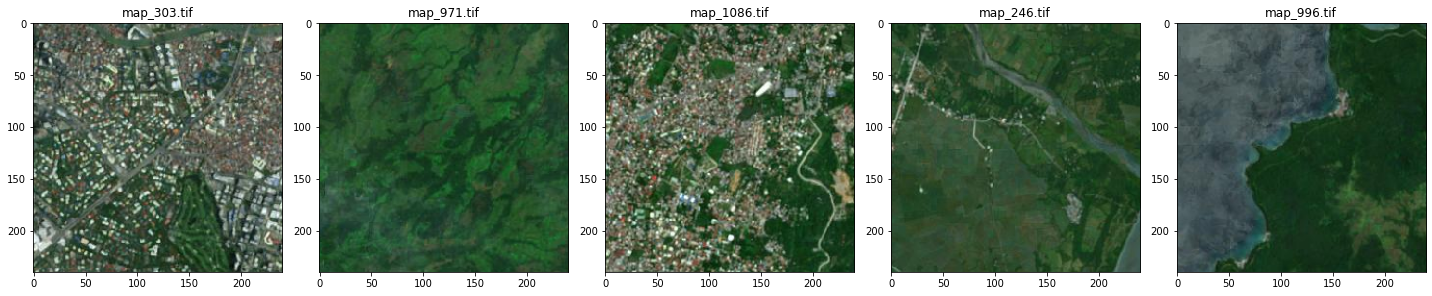

In [5]:
# Sample 5 tif images to display
output_folder = "data/daysat/2022/"
all_tif_files = [f for f in os.listdir(output_folder) if f.lower().endswith('.tif')]
sampled_files = random.sample(all_tif_files, 5)
sampled_file_paths = [os.path.join(output_folder, f) for f in sampled_files]

# Plot
fig, axes = plt.subplots(1,5,figsize=(20, 5))

# Iterate through each file and corresponding axis
for ax, tif_file in zip(axes, sampled_file_paths):
    with rasterio.open(tif_file) as src:
        bands = [src.read(i) for i in range(1, src.count + 1)]
        rgb_image = np.stack([bands[0], bands[1], bands[2]], axis=-1)  # RGB
        ax.imshow(rgb_image)
        ax.set_title(tif_file.split('/')[-1])
        
fig.tight_layout()

## Model Training

## Get Prediction Set

In [ ]:
from povertymapping.iso3 import get_region_name
from povertymapping.rollout_grids import get_region_filtered_bingtile_grids

In [ ]:
COUNTRY_CODE = "ph"
REGION = get_region_name(COUNTRY_CODE, code="alpha-2").lower()
ADMIN_LVL = "ADM2"
ZOOM_LEVEL = 14

In [ ]:
admin_grids_gdf = get_region_filtered_bingtile_grids(
    REGION, admin_lvl=ADMIN_LVL, quadkey_lvl=ZOOM_LEVEL, use_cache=False,
)

In [ ]:
pred_grid_file = 'phil_grids_2022'
rollout_date = "-".join(os.getcwd().split("/")[-2].split("-")[:3])
grid_save_path = f"./{rollout_date}-{COUNTRY_CODE}-rollout-grids.geojson"
admin_grids_gdf.to_file(grid_save_path, driver="GeoJSON", index=False)